In [1]:
import tensorflow as tf
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
img_array = cv2.imread("Train_Dataset/Closed_Eyes/s0036_00224_1_0_0_0_0_01.png",cv2.IMREAD_GRAYSCALE)

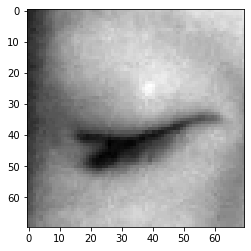

In [3]:
plt.imshow(img_array,cmap="gray")

In [4]:
img_array.shape

(70, 70)

In [5]:
Data_directory = "Train_Dataset"
Classes = ["Closed_Eyes","Opened_Eyes"]

for category in Classes:
    path = os.path.join(Data_directory , category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)

In [6]:
img_size =224

new_array = cv2.resize(backtorgb,(img_size,img_size))

In [7]:
#이미지를 읽고 데이터와 레이블을 배열로 변환
train_data=[]

def creat_train_data():
    for category in Classes:
        path=os.path.join(Data_directory , category)
        class_num = Classes.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
            backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
            new_array = cv2.resize(backtorgb,(img_size,img_size))
            train_data.append([new_array,class_num])

In [8]:
creat_train_data()

In [9]:
print(len(train_data))

10280


In [10]:
import random

random.shuffle(train_data)

In [11]:
X=[]
y=[]

for features,label in train_data:
    X.append(features)
    y.append(label)
    ##넘파이 배열로 이미지 변환
X = np.array(X).reshape(-1,img_size,img_size,3)

In [12]:
X.shape

(10280, 224, 224, 3)

In [13]:
## 정규화
X=X/255.0

In [14]:
Y=np.array(y)

In [15]:
# 데이터 저장
import pickle

pickle_out = open("X.pickles","wb")
pickle.dump(X,pickle_out)
pickle_out.close()

pickle_out = open("y.pickles","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [16]:
import pickle
pickle_in = open("X.pickles","rb")
X=pickle.load(pickle_in)

pickle_in = open("y.pickles","rb")
y=pickle.load(pickle_in)

In [17]:
## 딥러닝 모델 
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

In [18]:
model = tf.keras.applications.mobilenet.MobileNet()

In [19]:
## 전이학습
base_input = model.layers[0].input

In [20]:
base_out = model.layers[-4].output

In [21]:
Flat_layer = layers.Flatten()(base_out)
final_output = layers.Dense(1)(Flat_layer)
final_ouput = layers.Activation('sigmoid')(final_output)

In [22]:
new_model = keras.Model(inputs = base_input,outputs=final_output)

In [23]:
## 이진 분류 설정
new_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [24]:
## 훈련
early_stopping = EarlyStopping(patience = 4)
checkpoint_cb = keras.callbacks.ModelCheckpoint('nice-model.h5')
new_model.fit(X,Y,epochs=1,validation_split=0.2,callbacks=[early_stopping])
new_model.save_weights('model-weights.h5')
new_model.save('model-whole.h5')

257/257 [==============================] - 511s 2s/step - loss: 1.8303 - accuracy: 0.8722 - val_loss: 1.1310 - val_accuracy: 0.9246


In [25]:
## 예측용 모델
img_array = cv2.imread("Train_Dataset/Closed_Eyes/s0036_00225_1_0_0_0_0_01.png",cv2.IMREAD_GRAYSCALE)
backtorgb = cv2.cvtColor(img_array,cv2.COLOR_GRAY2RGB)
new_array = cv2.resize(backtorgb,(img_size,img_size))

In [26]:
X_input = np.array(new_array).reshape(1,img_size,img_size,3)
X_input.shape

(1, 224, 224, 3)

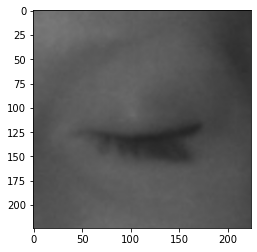

In [27]:
plt.imshow(new_array)

In [28]:
X_input=X_input/255.0

In [29]:
prediction = new_model.predict(X_input)
prediction

array([[-18.112833]], dtype=float32)

In [30]:
## 임의의 이미지 체크
img = cv2.imread('sad_man.jpg')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_eye.xml')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


In [31]:
eyes = eye_cascade.detectMultiScale(gray,1.1,4)

for(x,y,w,h)in eyes:
    cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)

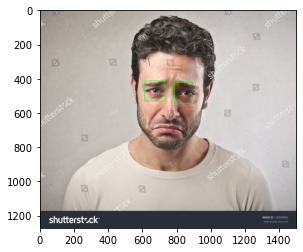

In [32]:
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))

In [38]:
##croping the eyes images-->눈만 짤라내기
eye_cascade =cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_eye.xml')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
eyes = eye_cascade.detectMultiScale(gray,1.1,4)

for x,y,w,h in eyes:
    roi_gray = gray[y:y+h,x:x+w]
    roi_color = img[y:y+h,x:x+w]
    eyess = eye_cascade.detectMultiScale(roi_gray)
    if(len(eyess)==0):
        print("눈이 감지 되지 않았습니다")
    else : 
        for(ex,ey,ew,eh) in eyess:
            eyes_roi = roi_color[ey:ey+eh,ex:ex+ew]

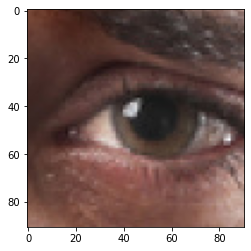

In [39]:
plt.imshow(cv2.cvtColor(eyes_roi , cv2.COLOR_BGR2RGB))

In [40]:
eyes_roi.shape

(91, 91, 3)

In [41]:
final_image = cv2.resize(eyes_roi,(224,224))
final_image = np.expand_dims(final_image,axis=0)
final_image = final_image/225.0

In [42]:
final_image.shape

(1, 224, 224, 3)

In [43]:
new_model.predict(final_image)

array([[25.350817]], dtype=float32)

In [46]:
##live video demo
## 눈 감지
import cv2
path = 'haarcascade_frontalface_default.xml'
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture(1)

if not cap.isOpened():
    cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("웹캡이 열리지 않았습니다")

while True:
    ret,frame = cap.read()
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades+'haarcascade_eye.xml')
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    eyes = eye_cascade.detectMultiScale(gray,1,1,4)
    for x,y,w,h in eyes:
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = frame[y:y+h,x:x+w]
        cv2.rectangle(frame , (x,y),(x+w,y+h),(0,255,0),2)
        eyes = eye_cascade.detectMultiScale(roi_gray)
        
        if len(eyess) == 0:
            print("눈이 감지 되지 않았습니다")
        else :
            for (ex,ey,ew,eh) in eyess:
                eyes_roi = roi_color[ey:ey+eh , ex:ex+ew]
        
        final_image = cv2.resize(eyes_roi,(224,224))
        final_image = np.expand_dims(final_image,axis=0)
        final_image = final_image/255.0
        
        Predictions = new_model.predict(final_image)
        if(Predictions>0):
            status = "Open"
        else:
            status = "Close"
            
        gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        print(faceCascade.empty())
        faces = faceCascade.detectMultiScale(gray,1.1,4)
        
        for(x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(0,255,0),2)
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        cv2.putText(frame,status,(50,50),font,3,(0,0,255),2,cv2.LINE_4)
        cv2.imshow('Drowsniess Dectection',frame)
        
        if cv2.waitKey & 0xFF == ord('q'):
            break
cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-kh7iq4w7\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'
